# Preprocessing

Here we define useful methods that preprocess the MIDI data into the form that we want. There are mainly 2 way we want to represent the data. One way is a 3D matrix of notes and whether it was sustained or not and a 2D matrix of velocity. Another way is a 3D matrix of (notes, duration, velocity). These two representation of the MIDI data will be used differently in 2 different style transfer tasks that we want to explore. We will definitely use representation 1 first and then try to see if representation 2 has merits

In [1]:
import os
import mido
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_midis(base_fpath):
    fpaths = []
    for (root, dirnames, filenames) in os.walk(base_fpath):
        fpaths += [os.path.join(root, filename) for filename in filenames]
    return [mido.MidiFile(fpath) for fpath in fpaths]
classicals = load_midis('TPD/classical/')
jazzs = load_midis('TPD/jazz/')

## Representation 1

We will have a 3D matrix of notes and whether it was sustatined from the previous note or not, as well as a 2D matrix of velocity.

In [ ]:
fpath = "TPD/classical/beethoven_opus22_1_format0.mid"
midi = mido.MidiFile(fpath)

### Gather MIDI information 

Before we dive into the representation of MIDI we need to gather basic information and determine whether the MIDI file that we are getting can be used. 

In [ ]:
good_midi = midi.type == 0
tempo = -1
numerator = 4
denominator = 4
for msg in midi.tracks[0]:
    if msg.is_meta and msg.type == 'time_signature':
        numerator = msg.numerator
        denominator = msg.denominator
        good_midi = denominator == 4
    if msg.is_meta and msg.type == 'set_tempo' and tempo == -1:
        tempo = msg.tempo
print(good_midi)
print(tempo)
print(midi.ticks_per_beat)
print(midi.type)
print(numerator, denominator)

### Generate time matrix

Here we will generate the matrix to represent out midi file. This matrix will first be blank. Depending on the size of the music we are getting we will have different sized matricies. the matrix follows the following order

Each row is a timestamp. We will tolerate only 8 ticks per beat (this is a 1/32 note). Each timestamp is $\frac{1}{8}$ beat.  Thus we will shove ticks_per_beat / 8 ticks into one tick. Any notes played between them will be considered as played on the same time.

First we need to find the duration in terms of beats of the midi file.


In [ ]:
list(midi)

In [3]:
# Ignore all non-timed messages
target_ticks_per_beat = 8
notes_to_keep_up = 88
notes_to_keep_down = 32
notes_range = notes_to_keep_up - notes_to_keep_down + 3
# cleaned_midi = [msg for msg in midi.tracks[0] if not msg.is_meta and hasattr(msg, 'time')]


In [ ]:
cumsum = np.floor(np.cumsum(np.array([msg.time for msg in midi])) \
                  / (tempo / target_ticks_per_beat * 1e-6)).astype(np.int32)

In [ ]:
cumsum

Now we can create our music matrix

In [ ]:
def process_msg(time, msg, last_on, notes_mat, velocity_mat):
    time = int(time)
    if msg.type == 'control_change':
        if msg.control == 64:
            note = notes_mat.shape[1] - 2
        elif msg.control == 67:
            note = notes_mat.shape[1] - 1
        else:
            return
        if msg.value <= 63 and last_on[note] >= 0:
            duration = time - last_on[note]
            if duration > 0:
                notes_mat[last_on[note]:time, note, 1] = 1
            last_on[note] = -1
        elif msg.value >= 64 and last_on[note] == -1:
            notes_mat[time, note, 0] = 1
            velocity_mat[time, note] = 0
            last_on[note] = time
    if msg.type == 'note_on' and msg.velocity > 0:
        note = int(msg.note) - notes_to_keep_down
        if note > notes_to_keep_up - notes_to_keep_down or note < 0:
            return 
        notes_mat[time, note, 0] = 1
        velocity_mat[time, note] = int(msg.velocity)
        last_on[note] = time
    elif (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
        note = int(msg.note) - notes_to_keep_down
        if note > notes_to_keep_up - notes_to_keep_down or note < 0 or last_on[note] < 0:
            return
        duration = time - last_on[note]
        if duration > 0:
            notes_mat[last_on[note]:time, note, 1] = 1
        if duration == 0:
            notes_mat[time, note, 1] = 1
        last_on[note] = -1
        

notes_mat = np.zeros((int(cumsum[-1]), notes_range, 2), dtype=np.int8)
velocity_mat = np.zeros((int(cumsum[-1]), notes_range), dtype=np.int16)
last_on = -np.ones(notes_range, dtype=np.int32)
midi_list = list(midi)
assert len(midi_list) == len(cumsum)
for i in range(len(midi_list)):
    time = cumsum[i]
    msg = midi_list[i]
    process_msg(time, msg, last_on, notes_mat, velocity_mat)
        
plt.figure(figsize=(8, 8))
plt.imshow(notes_mat[:300,:,0])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(velocity_mat[:300,:])

### Generate MIDI from music matrix

Now we can reliably generate a music matrix from a midi file. Instead of doing that, now we try to see if we can generate a midi music file from the music matrix. This is also to verify that our matrix representation contains enough information to recreate a music

In [ ]:
new_midi = mido.MidiFile(type=0)
new_midi.ticks_per_beat = target_ticks_per_beat
track = mido.MidiTrack()
new_midi.tracks.append(track)

track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
track.append(mido.MetaMessage('time_signature', numerator=numerator, denominator=denominator, 
                         clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

T, N, D = notes_mat.shape
notes_on = [False] * N
prev_event_t = 0
for t in range(200):
    for n in range(N-2):
        if notes_mat[t, n, 0] > 0:
            velocity = velocity_mat[t, n]
            track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=velocity, time=t-prev_event_t))
            prev_event_t = t
            notes_on[n] = True
        if notes_on[n] and notes_mat[t, n, 1] == 0:
            track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[n] = False
    if notes_mat[t, N-2, 0] == 1:
        track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
        prev_event_t = t
        notes_on[N-2] = True
    if notes_mat[t, N-1, 0] == 1:
        track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
        prev_event_t = t
        notes_on[N-2] = True
    if notes_on[N-2] and notes_mat[t, N-2, 1] == 0:
        track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
        prev_event_t = t
        notes_on[N-2] = False
    if notes_on[N-1] and notes_mat[t, N-1, 1] == 0:
        track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
        prev_event_t = t
        notes_on[N-1] = False



In [ ]:
new_midi.save('temp.midi')

### Processing multiple files into this format

Now that we have processed everything, we can try running the preprocessing steps on all our midi files and get our data matrix. First, let us abstract all the preprocessing done above into functions

In [5]:
def gather_midi_info(midi):
    if midi.type != 0:
        print('midi is not single track, ignore')
        return None
    midi_info = {}
    midi_info['tempo'] = -1
    midi_info['numerator'] = 4
    midi_info['denominator'] = 4
    for msg in midi.tracks[0]:
        if msg.is_meta and msg.type == 'time_signature':
            midi_info['numerator'] = msg.numerator
            midi_info['denominator'] = msg.denominator
            if msg.denominator != 4:
                print('midi is not quarter note beat, ignore')
                return None
        if msg.is_meta and msg.type == 'set_tempo' and midi_info['tempo'] == -1:
            midi_info['tempo'] = msg.tempo
    midi_info['ticks_per_beat'] = midi.ticks_per_beat
    return midi_info

def process_msg(time, msg, last_on, notes_mat, velocity_mat):
    time = int(time)
    if msg.type == 'control_change':
        if msg.control == 64:
            note = notes_mat.shape[1] - 2
        elif msg.control == 67:
            note = notes_mat.shape[1] - 1
        else:
            return
        if msg.value <= 63 and last_on[note] >= 0:
            duration = time - last_on[note]
            if duration > 0:
                notes_mat[last_on[note]:time, note, 1] = 1
            last_on[note] = -1
        elif msg.value >= 64 and last_on[note] == -1:
            notes_mat[time, note, 0] = 1
            velocity_mat[time, note] = 0
            last_on[note] = time
    if msg.type == 'note_on' and msg.velocity > 0:
        note = int(msg.note) - notes_to_keep_down
        if note > notes_to_keep_up - notes_to_keep_down or note < 0:
            return 
        notes_mat[time, note, 0] = 1
        velocity_mat[time, note] = int(msg.velocity)
        last_on[note] = time
    elif (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
        note = int(msg.note) - notes_to_keep_down
        if note > notes_to_keep_up - notes_to_keep_down or note < 0 or last_on[note] < 0:
            return
        duration = time - last_on[note]
        if duration > 0:
            notes_mat[last_on[note]:time, note, 1] = 1
        if duration == 0:
            notes_mat[time, note, 1] = 1
        last_on[note] = -1
        
def process_single_midi(midi):
    info = gather_midi_info(midi)
    if not info:
        return None
    midi_list = list(midi)
    cumsum = np.floor(np.cumsum(np.array([msg.time for msg in midi])) \
                  / (info['tempo'] / target_ticks_per_beat * 1e-6)).astype(np.int32)
    notes_mat = np.zeros((int(cumsum[-1]) + 1, notes_range, 2), dtype=np.int8)
    velocity_mat = np.zeros((int(cumsum[-1]) + 1, notes_range), dtype=np.int16)
    last_on = -np.ones(notes_range, dtype=np.int32)
    assert len(midi_list) == len(cumsum)
    for i in range(len(midi_list)):
        time = cumsum[i]
        msg = midi_list[i]
        process_msg(time, msg, last_on, notes_mat, velocity_mat)
    return notes_mat, velocity_mat, info

In [ ]:
a_notes, a_velocity, a_info = process_single_midi(classicals[100])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(a_notes[:100,:,0])

### Generate Music for single matrix

Before we run the algorithm on everything. We need to make sure it is correct. We will run our generate algorithm and compair it with the original

In [6]:
def generate(notes_mat, velocity_mat, bpm, seconds):
    new_midi = mido.MidiFile(type=0)
    new_midi.ticks_per_beat = target_ticks_per_beat
    track = mido.MidiTrack()
    new_midi.tracks.append(track)

    track.append(mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(bpm), time=0))
    track.append(mido.MetaMessage('time_signature', numerator=4, denominator=4, 
                             clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

    T, N, D = notes_mat.shape
    notes_on = [False] * N
    prev_event_t = 0
    Ty = seconds * bpm // 60 * target_ticks_per_beat
    print('generating {0} ticks of music'.format(Ty))
    for t in range(Ty):
        for n in range(N-2):
            if notes_mat[t, n, 0] > 0:
                velocity = velocity_mat[t, n]
                track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=velocity, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = True
            if notes_on[n] and notes_mat[t, n, 1] == 0:
                track.append(mido.Message('note_on', note=n + notes_to_keep_down, velocity=0, time=t-prev_event_t))
                prev_event_t = t
                notes_on[n] = False
        if notes_mat[t, N-2, 0] == 1:
            track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = True
        if notes_mat[t, N-1, 0] == 1:
            track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = True
        if notes_on[N-2] and notes_mat[t, N-2, 1] == 0:
            track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-2] = False
        if notes_on[N-1] and notes_mat[t, N-1, 1] == 0:
            track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
            prev_event_t = t
            notes_on[N-1] = False
    return new_midi

In [ ]:
a_midi = generate(a_notes, a_velocity, 120, 30)
a_midi.save('generated.midi')
classicals[100].save('original.midi')

Now that we compare the generation we know that it is correct!

In [7]:
classical_infos = []
classical_matrices = []
for midi in classicals:
    midi_info = gather_midi_info(midi)
    if not midi_info:
        continue
    matrix = list(process_single_midi(midi))
    classical_matrices += [matrix]
    classical_infos += [(midi_info['tempo'], midi_info['numerator'])]

In [8]:
jazz_infos = []
jazz_matrices = []
for midi in jazzs:
    midi_info = gather_midi_info(midi)
    if not midi_info:
        continue
    matrix = list(process_single_midi(midi))
    jazz_matrices += [matrix]
    jazz_infos += [(midi_info['tempo'], midi_info['numerator'])]

In [9]:
jazz_matrices[0][0].shape

(1597, 59, 2)

### Further Preprocessing

In [10]:
len(classical_matrices[0])

3

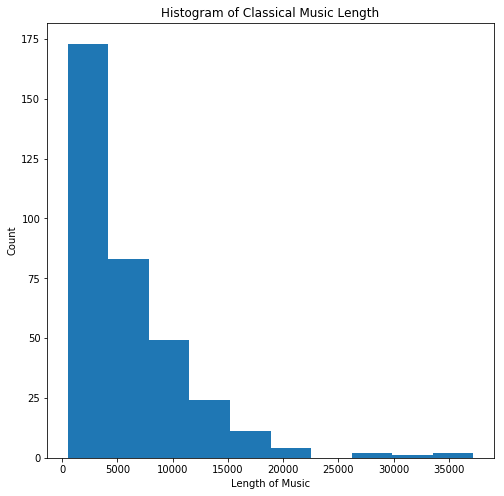

In [11]:
plt.figure(figsize=(8, 8))
plt.hist([x[0].shape[0] for x in classical_matrices])
plt.savefig('plots/classical_hist.png')
plt.title('Histogram of Classical Music Length')
plt.xlabel('Length of Music')
plt.ylabel('Count')
plt.show()

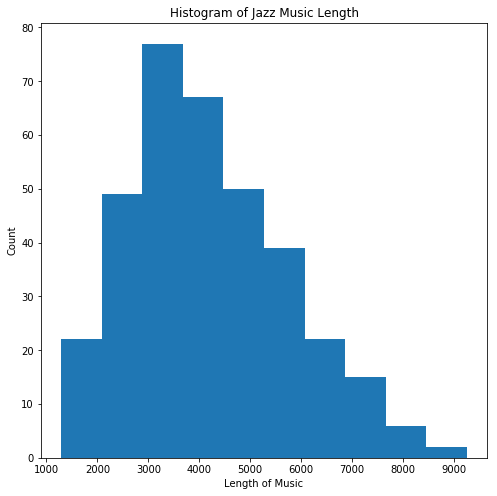

In [12]:
plt.figure(figsize=(8, 8))
plt.hist([x[0].shape[0] for x in jazz_matrices])
plt.savefig('plots/jazz_hist.png')
plt.title('Histogram of Jazz Music Length')
plt.xlabel('Length of Music')
plt.ylabel('Count')
plt.show()

No we will cut the music into 30 second fragments and treat each 30 second fragment as a training example. This will make our algorithm run faster while also reducing the amount of parameters need to make it work.

In [14]:
T_split = 30 * target_ticks_per_beat * (120 // 60) # seconds = ticks_per_beat * (beats_per_min / 60)

In [ ]:
def split(mats, T_split, n_songs=None):
    if n_songs is None:
        n_songs = len(mats)
    notes_splitted = []
    vel_splitted = []
    for i in range(min(len(mats), n_songs)):
        notes_mat = mats[i][0]
        vel_mat = mats[i][1]
        m, n, d = notes_mat.shape
        for j in range(m // T_split):
            notes_splitted += [notes_mat[(j*T_split) : ((j + 1)*T_split), :, :]]
            vel_splitted += [vel_mat[(j*T_split):((j+1)*T_split), :]]
    return np.stack(notes_splitted), np.stack(vel_splitted)

In [ ]:
classical_notes_splitted, classical_vel_splitted= split(classical_matrices, T_split)
jazz_notes_splitted, jazz_vel_splitted= split(jazz_matrices, T_split)
print(classical_notes_splitted.shape, classical_vel_splitted.shape)
print(jazz_notes_splitted.shape, jazz_vel_splitted.shape)

Now we attempt to stack each matrices. There will be 3 matrices. One for the notes, one for the velocities, and one for label (classical or jazz)

In [ ]:
m_classical = classical_notes_splitted.shape[0]
m_jazz = jazz_notes_splitted.shape[0]
notes = np.concatenate((classical_notes_splitted, jazz_notes_splitted), axis=0)
velocities = np.concatenate((classical_vel_splitted, jazz_vel_splitted), axis=0)
labels = np.concatenate((np.ones((m_classical, 1)), np.zeros((m_jazz, 1))), axis=0)
print(notes.shape, velocities.shape, labels.shape)

In [ ]:
np.save('matricies/notes.npy', notes)
np.save('matricies/velocities.npy', velocities)
np.save('matricies/labels.npy', labels)

We would also want a smaller subset of the music to train LSTM on. Here we will only take the first 30 second of EACH song.

In [22]:
small_classicals = []
for song in classical_matrices:
    notes_mat = song[0]
    small_classicals += [notes_mat[:T_split]]
small_cmatrix = np.stack(small_classicals, axis=0)
small_jazz = []
for song in jazz_matrices:
    notes_mat = song[0]
    small_jazz += [notes_mat[:T_split]]
small_jmatrix = np.stack(small_jazz, axis=0)
small_notes = np.concatenate((small_cmatrix, small_jmatrix), axis=0)
small_Y = np.concatenate((np.ones((len(small_classicals), 1)), np.zeros((len(small_jazz), 1))), axis=0)
np.save('matricies/small_notes.npy', small_notes)
np.save('matricies/small_Y.npy', small_Y)

## Representation 2

In this representation we will create a 3D array where each row is a timestamp. Each column is one of the 128 notes that the note was on + 2 damper notes, and each depth is (whether the note was and its velocity, and the duration of the note). This encodes almost all information about the music.

Additionally, we will also encode the 

In [ ]:
fpath = "TPD/classical/BENABD08.mid"
midi = mido.MidiFile(fpath)


In [ ]:
for msg in midi.tracks[0]:
    print(msg)

### Gather MIDI information 

Before we dive into the representation of MIDI we need to gather basic information and determine whether the MIDI file that we are getting can be used. 

In [ ]:
good_midi = midi.type == 0
tempo = -1
numerator = 4
denominator = 4
for msg in midi.tracks[0]:
    if msg.is_meta and msg.type == 'time_signature':
        numerator = msg.numerator
        denominator = msg.denominator
        good_midi = denominator == 4
    if msg.is_meta and msg.type == 'set_tempo' and tempo == -1:
        tempo = msg.tempo
print(good_midi)
print(tempo)
print(midi.ticks_per_beat)
print(midi.type)
print(numerator, denominator)

### Generate time matrix

Here we will generate the matrix to represent out midi file. This matrix will first be blank. Depending on the size of the music we are getting we will have different sized matricies. the matrix follows the following order

Each row is a timestamp. We will tolerate only 8 ticks per beat (this is a 1/32 note). Each timestamp is $\frac{1}{8}$ beat.  Thus we will shove ticks_per_beat / 8 ticks into one tick. Any notes played between them will be considered as played on the same time.

First we need to find the duration in terms of beats of the midi file.


In [ ]:
# Ignore all non-timed messages
cleaned_midi = [msg for msg in midi.tracks[0] if not msg.is_meta and hasattr(msg, 'time')]
cumsum = np.cumsum(np.array([msg.time for msg in cleaned_midi])) / (midi.ticks_per_beat / 8)

Now we can create our music matrix

In [ ]:
def process_msg(time, msg, last_on, matrix):
    time = int(time)
    if msg.type == 'control_change':
        if msg.control == 64:
            note = 128
        elif msg.control == 67:
            note = 129
        else:
            return
        if msg.value <= 63 and last_on[note] >= 0:
            duration = time - last_on[note]
            if duration > 0:
                matrix[last_on[note], note, 1] = duration
            last_on[note] = -1
        elif msg.value >= 64 and last_on[note] == -1:
            matrix[time, note, 0] = 127
            last_on[note] = time
    if msg.type == 'note_on' and msg.velocity > 0:
        note = int(msg.note)
        matrix[time, note, 0] = int(msg.velocity)
        last_on[note] = time
    elif (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)) and last_on[msg.note] >= 0:
        note = int(msg.note)
        duration = time - last_on[note]
        if duration > 0:
            matrix[last_on[note], note, 1] = duration
        

music_matrix = np.zeros((int(cumsum[-1]), 128 + 2, 2), dtype=np.int32)
last_on = -np.ones(128 + 2, dtype=np.int32)
for i in range(len(cleaned_midi)):
    time = cumsum[i]
    msg = cleaned_midi[i]
    process_msg(time, msg, last_on, music_matrix)
        
plt.figure(figsize=(8, 8))
plt.imshow(music_matrix[:127,:,0])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(music_matrix[:127,:,1])

### Generate MIDI from music matrix

Now we can reliably generate a music matrix from a midi file. Instead of doing that, now we try to see if we can generate a midi music file from the music matrix. This is also to verify that our matrix representation contains enough information to recreate a music

In [ ]:
new_midi = mido.MidiFile(type=0)
new_midi.ticks_per_beat = 8
track = mido.MidiTrack()
new_midi.tracks.append(track)

track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
track.append(mido.MetaMessage('time_signature', numerator=numerator, denominator=denominator, 
                         clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

T, N, D = music_matrix.shape
note_ends = np.zeros((T+1, N))
for t in range(T):
    for n in range(N):
        if music_matrix[t, n, 0] > 0:
            note_ends[music_matrix[t, n, 1] + t, n] = 1
prev_event_t = 0
for t in range(T):
    for n in range(N-2):
        velocity = music_matrix[t, n, 0]
        if velocity > 0:
            track.append(mido.Message('note_on', note=n, velocity=velocity, time=t-prev_event_t))
            prev_event_t = t
        if note_ends[t, n] == 1:
            track.append(mido.Message('note_on', note=n, velocity=0, time=t-prev_event_t))
            prev_event_t = t
    if music_matrix[t, N-2, 0] == 127:
        track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
        prev_event_t = t
    if music_matrix[t, N-1, 0] == 127:
        track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
        prev_event_t = t
    if note_ends[t, N-2] == 1:
        track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
        prev_event_t = t
    if note_ends[t, N-1] == 1:
        track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
        prev_event_t = t



In [ ]:
new_midi.save('temp.midi')

### Processing multiple files into this format

Now that we have processed everything, we can try running the preprocessing steps on all our midi files and get our data matrix. First, let us abstract all the preprocessing done above into functions

In [ ]:
def gather_midi_info(midi):
    if midi.type != 0:
        print('midi is not single track, ignore')
        return None
    midi_info = {}
    midi_info['tempo'] = -1
    midi_info['numerator'] = 4
    midi_info['denominator'] = 4
    for msg in midi.tracks[0]:
        if msg.is_meta and msg.type == 'time_signature':
            midi_info['numerator'] = msg.numerator
            midi_info['denominator'] = msg.denominator
            if msg.denominator != 4:
                print('midi is not quarter note beat, ignore')
                return None
        if msg.is_meta and msg.type == 'set_tempo' and midi_info['tempo'] == -1:
            midi_info['tempo'] = msg.tempo
    midi_info['ticks_per_beat'] = midi.ticks_per_beat
    return midi_info

def process_msg(time, msg, last_on, matrix):
    time = int(time)
    if msg.type == 'control_change':
        if msg.control == 64:
            note = 128
        elif msg.control == 67:
            note = 129
        else:
            return
        if msg.value <= 63 and last_on[note] >= 0:
            duration = time - last_on[note]
            if duration > 0:
                matrix[last_on[note], note, 1] = duration
            last_on[note] = -1
        elif msg.value >= 64 and last_on[note] == -1:
            matrix[time, note, 0] = 127
            last_on[note] = time
    if msg.type == 'note_on' and msg.velocity > 0:
        note = int(msg.note)
        matrix[time, note, 0] = int(msg.velocity)
        last_on[note] = time
    elif (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)) and last_on[msg.note] >= 0:
        note = int(msg.note)
        duration = time - last_on[note]
        if duration > 0:
            matrix[last_on[note], note, 1] = duration
        
def process_single_midi(midi):
    cleaned_midi = [msg for msg in midi.tracks[0] if not msg.is_meta and hasattr(msg, 'time')]
    cumsum = np.cumsum(np.array([msg.time for msg in cleaned_midi])) / (midi.ticks_per_beat / 8)
    music_matrix = np.zeros((int(cumsum[-1]) + 1, 128 + 2, 2), dtype=np.int32)
    last_on = -np.ones(128 + 2, dtype=np.int32)
    for i in range(len(cleaned_midi)):
        time = cumsum[i]
        msg = cleaned_midi[i]
        process_msg(time, msg, last_on, music_matrix)
    return music_matrix

In [ ]:
def load_midis(base_fpath):
    fpaths = []
    for (root, dirnames, filenames) in os.walk(base_fpath):
        fpaths += [os.path.join(root, filename) for filename in filenames]
    return [mido.MidiFile(fpath) for fpath in fpaths]
classicals = load_midis('TPD/classical/')
jazzs = load_midis('TPD/jazz/')

In [ ]:
a = process_single_midi(classicals[10])

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(a[:127,:,0])

In [ ]:
classical_infos = []
classical_matrices = []
for midi in classicals:
    midi_info = gather_midi_info(midi)
    if not midi_info:
        continue
    matrix = process_single_midi(midi)
    classical_matrices += [matrix]
    classical_infos += [(midi_info['tempo'], midi_info['numerator'])]

In [ ]:
jazz_infos = []
jazz_matrices = []
for midi in jazzs:
    midi_info = gather_midi_info(midi)
    if not midi_info:
        continue
    matrix = process_single_midi(midi)
    jazz_matrices += [matrix]
    jazz_infos += [(midi_info['tempo'], midi_info['numerator'])]

In [ ]:
jazz_matrices[0].shape

In [ ]:
np.save('matricies/classical_matrices.npy', classical_matrices)
np.save('matricies/jazz_matrices.npy', jazz_matrices)

In [ ]:
np.save('matricies/classical_infos.npy', classical_infos)
np.save('matricies/jazz_infos.npy', jazz_infos)

To verify that the music matrix generated is good, we will randomly pick a music and listen to it to see if it is ok.

In [ ]:
def generate(midi_info, music_matrix):
    new_midi = mido.MidiFile(type=0)
    new_midi.ticks_per_beat = 8
    track = mido.MidiTrack()
    new_midi.tracks.append(track)

    track.append(mido.MetaMessage('set_tempo', tempo=midi_info['tempo'], time=0))
    track.append(mido.MetaMessage('time_signature', numerator=midi_info['numerator'], 
                                  denominator=midi_info['denominator'], 
                                  clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))
    track.append(mido.MetaMessage('track_name', name='Test Track', time=0))

    T, N, D = music_matrix.shape
    note_ends = np.zeros((T+1, N))
    for t in range(T):
        for n in range(N):
            if music_matrix[t, n, 0] > 0:
                note_ends[music_matrix[t, n, 1] + t, n] = 1
    prev_event_t = 0
    for t in range(T):
        for n in range(N-2):
            velocity = music_matrix[t, n, 0]
            if velocity > 0:
                track.append(mido.Message('note_on', note=n, velocity=velocity, time=t-prev_event_t))
                prev_event_t = t
            if note_ends[t, n] == 1:
                track.append(mido.Message('note_on', note=n, velocity=0, time=t-prev_event_t))
                prev_event_t = t
        if music_matrix[t, N-2, 0] == 127:
            track.append(mido.Message('control_change', control=64, value=127, time=t-prev_event_t))
            prev_event_t = t
        if music_matrix[t, N-1, 0] == 127:
            track.append(mido.Message('control_change', control=67, value=127, time=t-prev_event_t))
            prev_event_t = t
        if note_ends[t, N-2] == 1:
            track.append(mido.Message('control_change', control=64, value=0, time=t-prev_event_t))
            prev_event_t = t
        if note_ends[t, N-1] == 1:
            track.append(mido.Message('control_change', control=67, value=0, time=t-prev_event_t))
            prev_event_t = t
    return new_midi


In [ ]:
classicals[10].save('original.midi')
new_midi = generate(gather_midi_info(classicals[10]), a)
new_midi.save('generated.midi')

The generated music sounds good! We will later use this method to generate music.